In [504]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import LSTM, Dense, Activation, TimeDistributed, Dropout, Lambda, RepeatVector, Input, Reshape
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import tensorflow
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import math


In [555]:
def seq2seq(feature_len, after_day, input_shape):

    # Encoder
    encoder_inputs = Input(shape=input_shape) # (timesteps, feature)
    encoder = LSTM(units=256, return_state=True,  name='encoder')
    #model.add(Dropout(0.5)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    states = [state_h, state_c]

    # Decoder
    reshapor = Reshape((1, 256), name='reshapor')
    decoder = LSTM(units=256, return_sequences=True, return_state=True, name='decoder')
    #model.add(Dropout(0.5)
    # Densor
    #tdensor = TimeDistributed(Dense(units=200, activation='linear', name='time_densor'))
    densor_output = Dense(units=feature_len, activation='linear', name='output')

    inputs = reshapor(encoder_outputs)
    #inputs = tdensor(inputs)
    all_outputs = []

    for _ in range(after_day):
        outputs, h, c = decoder(inputs, initial_state=states)

        #inputs = tdensor(outputs)
        inputs = outputs
        states = [state_h, state_c]

        outputs = densor_output(outputs)
        all_outputs.append(outputs)

    decoder_outputs = Lambda(lambda x: backend.concatenate(x, axis=1))(all_outputs)
    model = Model(inputs=encoder_inputs, outputs=decoder_outputs)

    return model

In [507]:
def normalize_data(data, scaler):
    minmaxscaler = scaler.fit(data)
    normalize_data = minmaxscaler.transform(data)

    return normalize_data
def inverse_normalize_data(data, scaler):
    for i in range(len(data)):
        data[i] = scaler.inverse_transform(data[i])

    return data

def normalize(df):
    min_max_scaler = MinMaxScaler()
    #df = df.drop(['date','adj_close'],axis=1)
    for col in df.columns: 
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))
    return df
def denormalize(normalized,original,feature='close'):
    original_value = original[feature].values.reshape(-1,1)
    normalized_value = normalized.reshape(-1,1)

    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    return min_max_scaler.inverse_transform(normalized_value)[:,0]

In [534]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def buildTrain(train, pastDay=30, futureDay=5,feature='close',drop=False):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(train[i+pastDay:i+pastDay+futureDay]))
        #Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][feature]))        
    return np.array(X_train), np.array(Y_train)
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def training_result(history):
    plt.title('Model loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('Losss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
def plot_predict(actual, predict,feature=15,shift=True):
    #file_path = 'images/result/{}.png'.format(file_name)

    fig = plt.figure(figsize=(15, 10))
    days = predict.shape[1]
    row_num = math.ceil(days/3)*100
    
    for i in range(days):
        ax = fig.add_subplot(row_num+31+i)
        if shift:
            ax.plot(actual[:,0,feature],label='actual',color='red')
        else:
            ax.plot(actual[:,i,feature],label='actual',color='red')
        ax.plot(predict[:,i,feature],label='predict',color='blue')
        if shift:
            ax.title.set_text(f'shift {i+1} Day')
        else:
            ax.title.set_text(f'Day {i+1}')
        ax.legend(loc='best')

In [508]:
scaler = MinMaxScaler(feature_range=(0, 1))
validate_percent = 0.8
time_step = 30
after_day = 7
batch_size = 64
epochs = 100
val_ratio = 0.33

In [495]:
#df = []
#with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
#    df = pickle.load(f)

all_df=[]
for train_data in os.listdir(os.path.join(os.getcwd(),'data')):
    with open(os.path.join(os.getcwd(),"data",train_data),'rb') as f:
        print(train_data)
        
        sub_df=pickle.load(f)#.iloc[:-60]
        #all_df.append(sub_df)
        


#df = pd.concat(all_df,axis=0, ignore_index=True)

#df.shape

1203.pickle
1217.pickle
2885.pickle
1218.pickle
2609.pickle
2498.pickle
2881.pickle
3034.pickle
2353.pickle
2449.pickle
1444.pickle
2308.pickle
2412.pickle
1216.pickle
3045.pickle
3008.pickle
2884.pickle
2504.pickle
1301.pickle
2344.pickle
3443.pickle
2505.pickle
2454.pickle
2330.pickle
1201.pickle
2618.pickle
2603.pickle
1707.pickle
2303.pickle
2610.pickle
2889.pickle
1215.pickle
2891.pickle
2368.pickle
2892.pickle
2103.pickle
0050.pickle
1734.pickle
2337.pickle
2886.pickle


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


(108356, 29)

In [556]:
scaler = MinMaxScaler(feature_range=(0, 1))
validate_percent = 0.8
time_step = 30
after_day = 7
batch_size = 64
epochs = 100
val_ratio = 0.33
#sub_df = df[['high','close','low','open']]
with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
    df = pickle.load(f)
sub_df=df.drop(['year','week','month','day','adj_close'],axis=1)
data = normalize_data(sub_df.copy(), scaler)

In [557]:
x_train,y_train=buildTrain(data, time_step,after_day,drop=False)
X_train, Y_train, X_val, Y_val = splitData(x_train, y_train, val_ratio)
X_train, Y_train = shuffle(X_train, Y_train)

In [558]:
feature_len = X_train.shape[2]
input_shape = (time_step, feature_len)
model = seq2seq(feature_len, after_day, input_shape)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 30, 24)]     0                                            
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 256), (None, 287744      input_31[0][0]                   
__________________________________________________________________________________________________
reshapor (Reshape)              (None, 1, 256)       0           encoder[0][0]                    
__________________________________________________________________________________________________
decoder (LSTM)                  [(None, 1, 256), (No 525312      reshapor[0][0]                   
                                                                 encoder[0][1]             

In [ ]:
callback = EarlyStopping(monitor="val_loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=1000, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
38/38 [==============================] - 5s 143ms/step - loss: 0.0762 - accuracy: 0.2736 - val_loss: 0.0392 - val_accuracy: 0.4270
Epoch 2/1000
38/38 [==============================] - 3s 73ms/step - loss: 0.0461 - accuracy: 0.4024 - val_loss: 0.0357 - val_accuracy: 0.4202
Epoch 3/1000
38/38 [==============================] - 3s 74ms/step - loss: 0.0442 - accuracy: 0.4134 - val_loss: 0.0349 - val_accuracy: 0.4427
Epoch 4/1000
38/38 [==============================] - 3s 72ms/step - loss: 0.0436 - accuracy: 0.4393 - val_loss: 0.0357 - val_accuracy: 0.4657
Epoch 5/1000
38/38 [==============================] - 3s 72ms/step - loss: 0.0415 - accuracy: 0.4473 - val_loss: 0.0347 - val_accuracy: 0.4352
Epoch 6/1000
38/38 [==============================] - 3s 72ms/step - loss: 0.0416 - accuracy: 0.4558 - val_loss: 0.0357 - val_accuracy: 0.4687
Epoch 7/1000
38/38 [==============================] - 3s 72ms/step - loss: 0.0414 - accuracy: 0.4558 - val_loss: 0.0328 - val_accuracy: 0.464

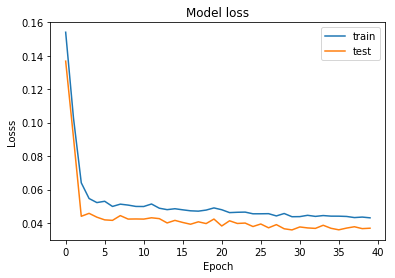

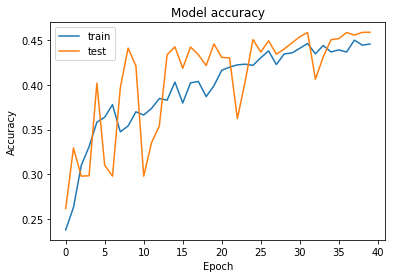

In [552]:
training_result(history)

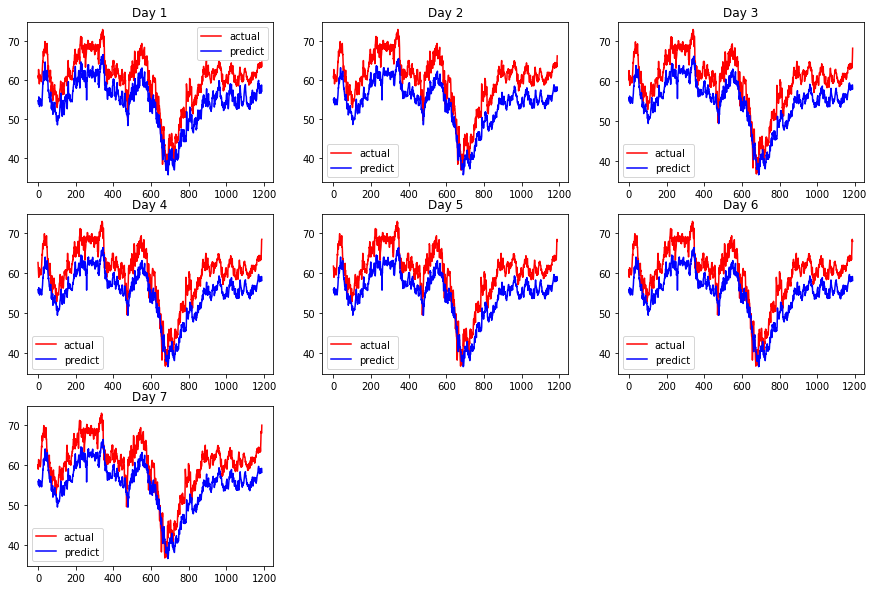

In [553]:
#with open(os.path.join(os.getcwd(),"data","2330.pickle"),'rb') as f:
#    df = pickle.load(f)
#scaler = MinMaxScaler(feature_range=(0, 1))
#normalize_data(df.drop(['year','week','month','day','adj_close'],axis=1), scaler)
#x_train,y_train=buildTrain(sub_df.copy(), time_step,after_day,drop=False)
#_, _, _, Y_val = splitData(x_train, y_train, val_ratio)
train_predict = model.predict(X_val.copy())
#print(train_predict.shape)
result = inverse_normalize_data(train_predict.copy(), scaler)

actual = inverse_normalize_data(Y_val.copy(), scaler)
#actual = inverse_normalize_data(Y_val, scaler)
plot_predict(actual, result,shift=False)

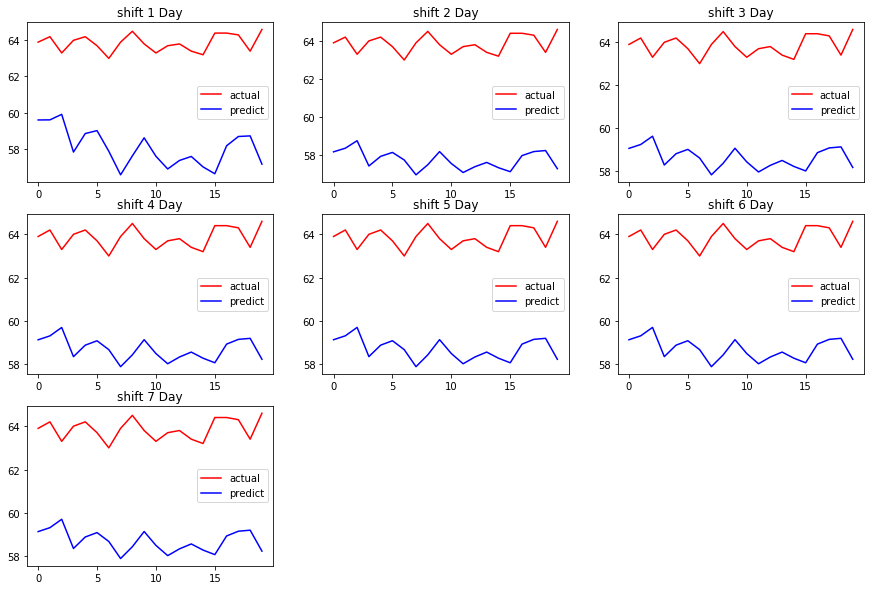

In [554]:
plot_predict(actual[-20:], result[-20:])